In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.pyplot import cm

from pygsp import graphs, plotting
import networkx as nx

In [15]:
def random_graph_r_dist(x, y, r):
    
    N = len(x)
    
    A = np.zeros((N,N), dtype=int)
    
    for i in range(N):
        for j in range(i+1,N):
            if (x[i]-x[j])**2+(y[i]-y[j])**2<=r**2 and i!=j:
                A[i][j] = 1
                A[j][i] = 1
    return A

In [16]:
def fusion_node(A, R0):
    
    N = len(A)
    
    A_R0 = np.linalg.matrix_power(np.identity(N) + A, R0)
    
    V = set(range(N))
    
    Q = np.array(np.random.randint(N))
    
    U = set(np.nonzero(A_R0[Q])[0])
    
    W  = V - U
    
    for i in range(1, N):
        
        
        j = np.random.choice(list(W))
        
        if len(set(np.nonzero(A_R0[j])[0]) & U) == 0:
            
            Q = np.append(Q, j)
            U = (U | set(np.nonzero(A_R0[j])[0]))
            W = (W - set(np.nonzero(A_R0[j])[0]))
                 
        else:
                 
            W = (W - {j})
                
        if len(W) == 0:
                 
                 break
    
    return Q

In [17]:
def voronoi_diagram(A, Q, R0):
    
    N = len(A)
    
    A_R0 = np.linalg.matrix_power(np.identity(N) + A, R0)
    
    D_q = list()
    
    V = set(range(N))
    
    for q in Q:
        
        D_q.append( set((np.nonzero(A_R0[q])[0])) )
        
        V = (V - set(np.nonzero(A_R0[q])[0]))  
        
    for r in range(R0):
        
        A_R0 = np.matmul(A_R0, np.identity(N) + A)
        
        for q in range(len(Q)):
            
            for i in V:
                
                if A_R0[Q[q]][i] != 0:
                    
                    D_q[q] = ( D_q[q] | {i} ) 
                    
                    V = ( V - {i} )
    
    return D_q

In [18]:
def neighbor_extension(A, Q, D, R):
    
    N = len(A)
    
    V = range(N)
    
    A_R = np.linalg.matrix_power(np.identity(N) + A, R)
    
    #Dq = voronoi_diagram(A, Q, R0)
    
    D_qR = D[:]
    
    for q in range(len(D)):
        
        for i in D[q]:
            
            D_qR[q] = ( D_qR[q] | set(np.nonzero(A_R[i])[0]) ) 
                
    return D_qR

In [19]:
def fusion_center_connect(A, Q, D, M):
    
    N_Q = len(Q)
    
    AQ = np.zeros((N_Q,N_Q), dtype=int)
    
    DqR2m = neighbor_extension(A, Q, D, M)
    
    for q in range(len(D)):
        
        for p in range(q+1, len(D)):
            
            if len(DqR2m[q].intersection(D[p])) !=0:
                
                AQ[q][p] = 1
                AQ[p][q] = 1
                
                
    return AQ
    
    

In [26]:
N = 1024

R0 = 5

R = 3

m = 1

G = graphs.Sensor(N, distribute=True )#, seed=20)
#G = graphs.Ring(N, 1 )#, seed=20)
A = G.A.toarray()*1 # Adjacency matrix
xy = np.array( G.coords ) # Coordinates of a nodes

x = xy[:,0]
y = xy[:,1]

# x = np.random.rand(N)
# y = np.random.rand(N)

# r = (5/N)**(0.5)

#A = random_graph_r_dist(x, y, r)

Q = fusion_node(A, R0)

D_q = voronoi_diagram(A, Q, R0)

#D_qR2m = neighbor_extension(A, Q, D_q, R+2*m)

A_qr2m = fusion_center_connect(A, Q, D_q, R+2*m)




<Figure size 648x216 with 0 Axes>

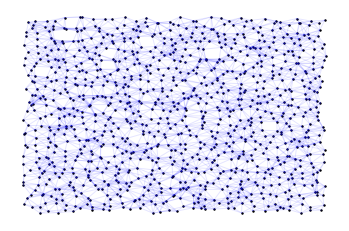

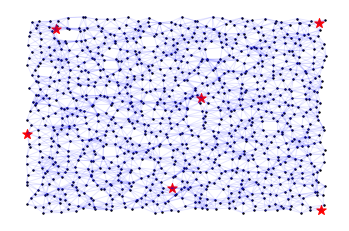

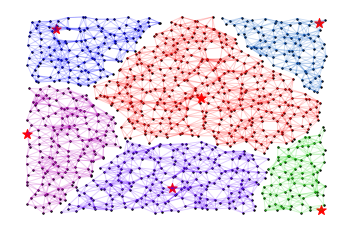

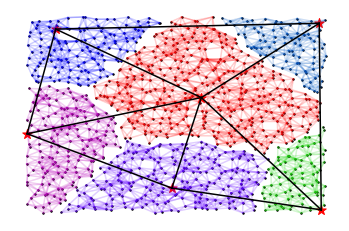

In [27]:
#--------------------------------------------------------------------
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9, 3))

fig, ax = plt.subplots()

for i in range(N):
    for j in range(i+1,N):
        if A[i,j] != 0:
            ax.plot([x[i],x[j]], [y[i],y[j]], 'b-', linewidth = 1, alpha=0.1)

ax.scatter(x, y, s = 2, c = 'k', marker = 'o')
#ax.set_title('Graph')
ax.axis('off')
ax.set_aspect('auto')
#ax.set_rasterized(True)
#plt.savefig('graph.pdf', format='pdf', bbox_inches='tight')
plt.savefig('graph.jpg', format='jpg', bbox_inches='tight')
plt.show()

#--------------------------------------------------------------------

fig, ax2 = plt.subplots()

for i in range(N):
    for j in range(i+1,N):
        if A[i,j] != 0:
            ax2.plot([x[i],x[j]], [y[i],y[j]],'b-', linewidth = 1, alpha=0.1)

ax2.scatter(x, y, s = 2, c = 'k', marker = 'o')
ax2.scatter(x[Q], y[Q], s = 100, c = 'r', marker = '*')
#ax2.set_title('Fusion Nodes')
ax2.axis('off')
#ax2.set_rasterized(True)
#plt.savefig('graph_fusion.pdf', format='pdf', bbox_inches='tight')
plt.savefig('graph_fusion.jpg', format='jpg', bbox_inches='tight')
plt.show()

#--------------------------------------------------------------------

colors = cm.prism(np.linspace(0, 1, 2*len(Q)))

fig, ax3 = plt.subplots()

for q in range(len(Q)):
    for i in D_q[q]:
        for j in D_q[q]:
            if A[i,j] != 0:
                ax3.plot([x[i],x[j]], [y[i],y[j]], color = colors[2*q], linewidth = 1, alpha=0.1)

ax3.scatter(x, y, s = 2, c = 'k', marker = 'o')
ax3.scatter(x[Q], y[Q], s = 100, c = 'r', marker = '*')
#ax3.set_title('Voronoi Diagram')
ax3.axis('off')
#ax3.set_rasterized(True)
#plt.savefig('voronoi.pdf', format='pdf', bbox_inches='tight')
plt.savefig('voronoi.jpg', format='jpg', bbox_inches='tight')

plt.show()

fig, ax4 = plt.subplots()

for q in range(len(Q)):
    for i in D_q[q]:
        for j in D_q[q]:
            if A[i,j] != 0:
                ax4.plot([x[i],x[j]], [y[i],y[j]], color = colors[2*q], linewidth = 1.5, alpha=0.1)            


for i in range(len(Q)):
    for j in range(i+1, len(Q)):
            if A_qr2m[i,j] != 0:
                ax4.plot([x[Q[i]],x[Q[j]]], [y[Q[i]],y[Q[j]]], color = 'k', linewidth = 1.5)

ax4.scatter(x, y, s = 2, c = 'k', marker = 'o')
ax4.scatter(x[Q], y[Q], s = 100, c = 'r', marker = '*')
#ax4.set_title('Fusion Network')
ax4.axis('off')
#ax4.set_rasterized(True)
#plt.savefig('fusion_network.pdf', format='pdf', bbox_inches='tight')
plt.savefig('fusion_network.jpg', format='jpg', bbox_inches='tight')

plt.show()


In [28]:
# prints number of nodes for each fusion center

for i in range(len(Q)):
    print([x[Q[i]],y[Q[i]]])
    print(len(D_q[i]))
    

[0.5833703938432846, 0.5881943254595549]
352
[0.0017555889639541133, 0.4039613645371932]
159
[0.48499665022339866, 0.1274197285398306]
212
[0.09725542393029638, 0.9366538704939984]
130
[0.976879007737935, 0.9661951811054078]
91
[0.9836568916289494, 0.016677533397134618]
80


In [17]:
# # Find Beurling Dimension

# M = 1 
# B = np.identity(N)

# a = []
# b = []

# for k in range(N):
#     B = np.matmul((np.identity(N)+ A), B)
#     temp = []
    
#     for i in range(N):
#         temp.append(len(set(np.nonzero(B[i])[0])))
    
#     a.append(max(temp)/((k+2)**(2)))
#     b.append(min(temp))
#     if  b[k] < N:
#         M = M+1
#     else:
#         break

# print(max(a))

0.75


In [24]:
#filename=''.join(['graph', str(N)])
#np.savez(filename, AdjacencyMatrix=A, Coordinate_x=x, Coordinate_y=y, FusionNodes = Q, VoronoiDiagramNodeSet = D_q, FusionConnectionMatrix = A_qr2m)